<a href="https://colab.research.google.com/github/Limitlessmatrix/AI_Art_tools/blob/main/Copy_of_extract_correspondence_from_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install dependencies & download data (~5 mins)

!pip install --upgrade --no-cache-dir gdown -q
!python -m pip install git+https://github.com/yenchenlin/link.git -q


import torch
import numpy as np
from link.david import renormalize, paintwidget, labwidget, show
from link import util
import time
import cv2
from glob import glob
from PIL import Image
from torchvision import transforms

# Download data
!gdown 1Lo8hwmPfq9xfjpzSYqP1iNL-3FElmLeZ
!unzip -q fork.zip

def reprojection(uv_A, z_A, c2w_A, c2w_B, K):
    """
    Args
        uvs_A: of shape (n_uvs, 2) 
    """
    pt_z_A = z_A[uv_A[1], uv_A[0]][None, :, None]  # (1, n_depths, 1)
    n_depths = pt_z_A.shape[1]
    xyz_A_camera = (np.stack([uv_A[0], uv_A[1], 1])[None, None, :] * pt_z_A) @ np.linalg.inv(K).T
    # xyz_A_camera has shape (1, n_depths, 3).
    
    xyz_A_world = np.concatenate([xyz_A_camera, np.ones([1, n_depths, 1])], axis=2) @ c2w_A.T
    # xyz_A_world has shape (1, n_depths, 4).
    uvs_B = (xyz_A_world @ np.linalg.inv(c2w_B).T)[:, :, :3] @ K.T
    uvs_B = (uvs_B[:, :, :2] / uvs_B[:, :, 2:]).astype(np.int32)
    return uvs_B

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1Lo8hwmPfq9xfjpzSYqP1iNL-3FElmLeZ
To: /content/fork.zip
100% 567M/567M [00:11<00:00, 51.4MB/s]



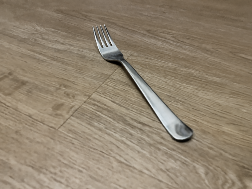
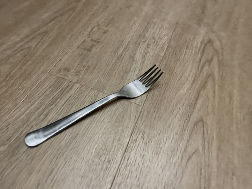
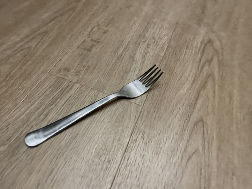

In [ ]:
#@title Interactive visualization of correspondences
#@markdown Click on a pixel in the left image and visualize its correspondence in the right image.

#@markdown To switch image pairs, just click on the play button again.

n_imgs = len(glob("./renderonly_train_199999/rgb/*.png"))

src_idx = np.random.randint(n_imgs)
tgt_idx = np.random.randint(n_imgs)

src_img = Image.open(f'./renderonly_train_199999/rgb/{src_idx:06}.png')
tgt_img = Image.open(f'./renderonly_train_199999/rgb/{tgt_idx:06}.png')
src_z = np.load(f'./renderonly_train_199999/z/{src_idx:06}.npy')
tgt_z = np.load(f'./renderonly_train_199999/z/{tgt_idx:06}.npy')
src_weight = np.load(f'./renderonly_train_199999/weight/{src_idx:06}.npy')
tgt_weight = np.load(f'./renderonly_train_199999/weight/{tgt_idx:06}.npy')
src_c2w = np.loadtxt(f'./renderonly_train_199999/pose/{src_idx:06}.txt')
tgt_c2w = np.loadtxt(f'./renderonly_train_199999/pose/{tgt_idx:06}.txt')
K = np.loadtxt(f'./renderonly_train_199999/intrinsics.txt')

# Convert poses from OpenCV to OpenGL
src_c2w = util.convert_pose(src_c2w)
tgt_c2w = util.convert_pose(tgt_c2w)

W, H = src_img.size
src_img_tensor = transforms.ToTensor()(src_img)
tgt_img_tensor = transforms.ToTensor()(tgt_img)

src_painter = paintwidget.PaintWidget(
    oneshot=False, width=W, height=H, 
    brushsize=1, save_sequence=False, track_move=True) # , on_move=True)
src_painter.image = renormalize.as_url(src_img_tensor, source='pt')
img_url = renormalize.as_url(tgt_img_tensor, source='pt')
img_html = '<img src="%s"/>'%img_url
output_div = labwidget.Div(img_html)

counter = 0
prev_time = time.time()
update_freq = 0.5 # mouse time intervals;  
# decrease update_freq to reduce lagging, but colab is kind of slow

def probe_changed(c):
    global counter
    global prev_time
    counter += 1
    curr_time = time.time()
    if curr_time - prev_time < update_freq:
        return
    prev_time = time.time()
    
    u_A = int(src_painter.px)
    v_A = int(src_painter.py)
    uvs_B = reprojection([u_A, v_A], src_z, src_c2w, tgt_c2w, K)
    
    img_A_draw = np.array(src_img).copy()
    img_B_draw = np.array(tgt_img).copy()
    color = tuple((255*np.random.rand(3)).tolist())
    for idx_pt in range(uvs_B.shape[0]):
        img_A_draw = cv2.circle(img_A_draw, tuple([u_A, v_A]), 3, color, -1)
        img_url = renormalize.as_url(
            transforms.ToTensor()(img_A_draw),
            source='pt'
        )
        src_painter.image = img_url
        
        for idx_depth in range(uvs_B.shape[1]):
            img_B_overlay = img_B_draw.copy()
            img_B_overlay = cv2.circle(img_B_overlay, tuple(uvs_B[idx_pt][idx_depth]), 3, color, -1)
            alpha = src_weight[v_A, u_A][idx_depth] * 10
            img_B_draw = cv2.addWeighted(img_B_overlay, alpha, img_B_draw, 1 - alpha, 0)
    img_url = renormalize.as_url(
        transforms.ToTensor()(img_B_draw),
        source='pt'
    )
    img_html = '<img src="%s"/>'%img_url
    output_div.innerHTML = img_html
    
src_painter.on('mask_buffer', probe_changed)

show.a([src_painter], cols=2)
show.a([output_div], cols=2)

show.flush()